In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
plt.style.use('dark_background')

In [3]:
# load the dataset
df = pd.read_csv('/content/drive/MyDrive/Tensorflow/TimeSeries/AirPassengers.csv')
print(df.dtypes)
df.head()

Month          object
#Passengers     int64
dtype: object


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Passengers    int64
dtype: object
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


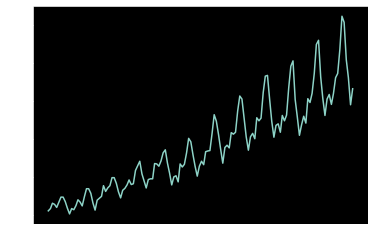

In [4]:
df['Month'] = pd.to_datetime(df['Month'])
df['Passengers']=df['#Passengers']
df.set_index('Month', inplace=True) 
df = df.drop(columns = ['#Passengers'])
print(df.dtypes)
print(df.head())
plt.plot(df['Passengers'])

In [41]:
#Convert pandas dataframe to numpy array
dataset = df.values
dataset = dataset.astype('float32') #Convert values to float

In [42]:
# Normalization is optional but recommended for neural network as certain 
# activation functions are sensitive to magnitude of numbers. 
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [43]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [45]:
# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as 
#input variables to predict the next time period.

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)


'''
from keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
seq_size = 20 # Number of time steps to look back
#Use TimeseriesGenerator to organize training data into the right format
batch_size = 1
train_generator = TimeseriesGenerator(train.reshape(-1), train.reshape(-1), length=seq_size, batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train)) # 95
print("Total number of samples in the generated data = ", len(train_generator)) # 55
#Also generate validation data
validation_generator = TimeseriesGenerator(test.reshape(-1), test.reshape(-1), length=seq_size, batch_size=batch_size)
'''

'\nfrom keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data\nseq_size = 20 # Number of time steps to look back\n#Use TimeseriesGenerator to organize training data into the right format\nbatch_size = 1\ntrain_generator = TimeseriesGenerator(train.reshape(-1), train.reshape(-1), length=seq_size, batch_size=batch_size)\nprint("Total number of samples in the original training data = ", len(train)) # 95\nprint("Total number of samples in the generated data = ", len(train_generator)) # 55\n#Also generate validation data\nvalidation_generator = TimeseriesGenerator(test.reshape(-1), test.reshape(-1), length=seq_size, batch_size=batch_size)\n'

In [ ]:
# print a couple of samples...
print((trainX, trainY))

''' 
x, y = train_generator[0]
print(x)
print(y)
'''

In [47]:
#Stacked LSTM with 1 hidden dense layer
#reshape input to be [samples, time steps, features]
trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
#print('Train...')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          19200     
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 3s - loss: 0.0760 - val_loss: 0.3796
Epoch 2/100
3/3 - 0s - loss: 0.0553 - val_loss: 0.2915
Epoch 3/100
3/3 - 0s - loss: 0.0378 - val_loss: 0.2146
Epoch 4/100
3/3 - 0s - loss: 0.0245 - val_loss: 0.1490
Epoch 5/100
3/3 - 0s - loss: 0.0154 - val_loss: 0.0962
Epoch 6/100
3/3 - 0s - loss: 0.0104 - val_loss: 0.0586
Epoch 7/100
3/3 - 0s - loss: 0.0089 - val_loss: 0.0368
Epoch 8/100
3/3 - 0s - loss: 0.0097 - val_loss: 0.0273
Epoch 9/100
3/3 - 0s - loss: 0.0108 - val_loss: 0.0246
Epoch 10/100
3/3 - 0s - loss: 0.0107 - val_loss: 0.0255
Epoch 11/100
3/3 - 0s - loss: 0.0095 - val_loss: 0.0289
Epoch 12/100
3/3 - 0s - loss: 0.0083 - val_loss: 0.0342
Epoch 13/100
3/3 - 0s - loss: 0.0075 - val_loss: 0.0394
Epoch 14/100
3/3 - 0s - loss: 0.0071 - val_loss: 0.0423
Epoch 15/100
3/3 - 0s - loss: 0.0070 - val_loss: 0.0421
Epoch 16/100
3/3 - 0s - loss: 0.0068 - val_loss: 0.0387
Epoch 17/100
3/3 - 0s - loss: 0.0064 - val_loss: 0.0338
Epoch 18/100
3/3 - 0s - loss: 0.0060 - val_loss: 0.0289
E

In [49]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
#Bidirectional LSTM
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
##For some sequence forecasting problems we may need LSTM to learn
## sequence in both forward and backward directions
#from keras.layers import Bidirectional
#model = Sequential()
#model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(None, seq_size)))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mean_squared_error')
#model.summary()
#print('Train...')
# model.fit(trainX, trainY, validation_data=(testX, testY),
#           verbose=2, epochs=100)

In [ ]:
# ConvLSTM
# #The layer expects input as a sequence of two-dimensional images, 
# #therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

# trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
# testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

# model = Sequential()
# model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
# model.add(Flatten())
# model.add(Dense(32))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mean_squared_error')
# model.summary()
# print('Train...')
# model.fit(trainX, trainY, validation_data=(testX, testY),
#           verbose=2, epochs=100)

In [50]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Train Score: 19.76 RMSE
Test Score: 48.68 RMSE


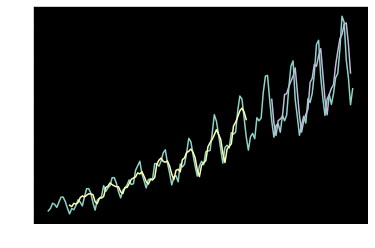

In [51]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()